In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pytesseract

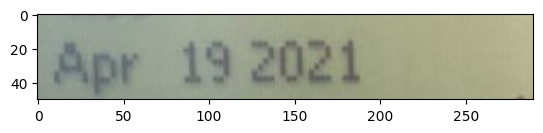

In [2]:
file_name = 'temp/date_erg01.jpg'
image = cv2.imread(file_name)
psm = '--psm 13'
plt.imshow(image)


In [38]:
def noise_removal(image):
    kernel = np.ones((2, 2), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    kernel = np.ones((2, 2), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 5)
    return (image)

In [39]:
def pre_process(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    no_noise = noise_removal(thresh)
    no_noise_color = cv2.cvtColor(no_noise, cv2.COLOR_GRAY2RGB)
    return no_noise_color

In [40]:
def extract(pp_image):
    gray = cv2.cvtColor(pp_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (1,1), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = np.ones((1,1),np.float32)/25
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, blur, iterations=1)
    data = pytesseract.image_to_string(opening, lang='eng', config=psm)
    return data, opening


Apr 192021



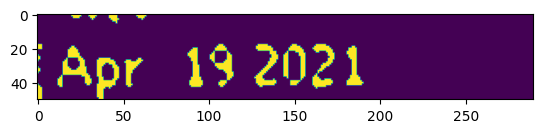

In [41]:
pre_processed_image = pre_process(image)
data, pic = extract(pre_processed_image)
print(data)
plt.imshow(pic)


# Full Extraction

{'wo': 'S00', 'date': 'Jal G1 eee', 'summary': 'Fe 2000 S47 31', 'time': 'leds :35.9 litte 135.1 L135', 'dist': 'i BT) 12013 1600 2000', 'split': '1:46.3 1:57. S77 See 154.1', 'sr': '23 2 24'}


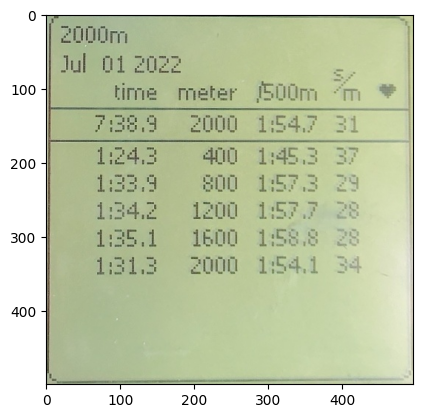

In [3]:
file_name = 'temp/cr_erg02.jpg'
image = cv2.imread(file_name)
plt.imshow(image) 

def preprocess(image): #image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bw_gaussian = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,6)
    # noise removal
    image = bw_gaussian
    kernel = np.ones((2,2), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    kernel = np.ones((2, 2), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image 

def snip(img)->dict:
    sr = img[182:400, 380:440]
    split = img[180:400, 280:385]
    dist = img[180:400, 180:280]
    time = img[180:400, 50:180]
    summary = img[135:175, 50:480]
    date = img[47:100, 10:225]
    workout = img[15:55, 10:150]
    snips = {'wo':workout, 'date':date, 'summary':summary, 'time':time, 'dist':dist, 'split':split, 'sr':sr}
    return snips

def extract_data(snips:dict)->dict:
    ocr_dict = {}
    for s in snips:
        if s in ['wo', 'date', 'summary']:
            psm = '--psm 13'
        else:
            psm ='--psm 6'
        gray = cv2.cvtColor(snips[s], cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (1,1), 0)
        thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        data = pytesseract.image_to_string(thresh, lang='eng', config=psm)
        ocr_dict[s] = data
    return ocr_dict

def basic_clean(ocr_dict:dict):
    for key in ocr_dict:
        ocr_dict[key] = ocr_dict[key].strip('\n\'"~|°`‘-!“ [()><')
        ocr_dict[key]=ocr_dict[key].replace("\n", ' ')
        ocr_dict[key]=ocr_dict[key].replace(",", '.')
        s2 = ""
        for i in range(len(ocr_dict[key])):
            if not ocr_dict[key][i] in ['\\','|','-', '“']:
                s2 += ocr_dict[key][i]
        ocr_dict[key] = s2
        if not key == 'date':
            ocr_dict[key]=ocr_dict[key].replace("A", '4')
    return ocr_dict

clean_ocr = basic_clean(extract_data(snip(preprocess(image))))

# img = preprocess(image)
# snips:dict = snip(img)
# ocr_dict:dict = extract_data(snips)
# clean_ocr:dict = basic_clean(ocr_dict)

print(clean_ocr)